In [1]:
import pandas as pd

In [2]:
path = 'C:\\Users\\USER\\Downloads\\amz_uk_price_prediction_dataset\\amz_uk_price_prediction_dataset.csv'
products_uk_df = pd.read_csv(path)

In [3]:
products_uk_df.sample(3)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
2429528,2807738,B0BPYD4783,"48V 70Ah Lifepo4 Battery,10+ Years Lifetime,De...",0.0,0,6184.99,False,0,Motorbike Batteries
682041,735015,B0BQMFJDRC,2 Pcs Silicone Air Fryer Liner for Ninja AF400...,4.4,572,7.99,False,700,Small Kitchen Appliances
573604,618001,B07D4RQHHH,"""Scrub Coffee Mug"" 11oz CUP Sassy Funny Mug",5.0,1,8.99,False,0,Handmade Kitchen & Dining


Part 1: Analyzing Best-Seller Trends Across Product Categories

In [4]:
#Create a crosstab between the product category and the isBestSeller status
pd.crosstab(products_uk_df['category'], products_uk_df['isBestSeller'])

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [6]:
#Pick the catergories that are more prevalent as a best-seller
best_sellers = products_uk_df[products_uk_df['isBestSeller'] == True]
best_sellers['category'].value_counts()

category
Grocery                   556
Health & Personal Care    552
Baby                      341
Sports & Outdoors         330
Power & Hand Tools        306
                         ... 
Cycling Shoes               1
Tennis Shoes                1
USB Hubs                    1
Desktop PCs                 1
Camcorders                  1
Name: count, Length: 260, dtype: int64

In [7]:
#Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(products_uk_df['category'], products_uk_df['isBestSeller'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square: {chi2}')
print(f'p-value: {p}')
print(f'Degrees of freedom: {dof}')
print('Expected: ')
print(expected)

#I conclude that there is a relantionship between the product category and the isBestSeller status

Chi-square: 36540.20270061387
p-value: 0.0
Degrees of freedom: 295
Expected: 
[[2.47190130e+02 8.09870149e-01]
 [4.05371878e+03 1.32812173e+01]
 [2.49183599e+02 8.16401360e-01]
 [1.69145827e+03 5.54173243e+00]
 [2.53170536e+02 8.29463782e-01]
 [8.50214439e+03 2.78556144e+01]
 [1.06650580e+02 3.49419782e-01]
 [2.57157474e+02 8.42526204e-01]
 [9.51781673e+03 3.11832664e+01]
 [1.50008526e+04 4.91473619e+01]
 [9.32544700e+03 3.05530045e+01]
 [2.38219520e+02 7.80479700e-01]
 [3.22941944e+03 1.05805616e+01]
 [9.44704859e+03 3.09514084e+01]
 [6.68808779e+03 2.19122125e+01]
 [5.26275760e+02 1.72423967e+00]
 [1.90296531e+04 6.23469391e+01]
 [2.77191835e+03 9.08164873e+00]
 [2.53170536e+02 8.29463782e-01]
 [4.04674164e+02 1.32583581e+00]
 [1.92489346e+04 6.30653723e+01]
 [3.10482764e+03 1.01723609e+01]
 [2.04330551e+02 6.69449115e-01]
 [6.28839730e+03 2.06027047e+01]
 [5.23385231e+03 1.71476942e+01]
 [9.52180367e+03 3.11963288e+01]
 [2.48186864e+02 8.13135755e-01]
 [9.46598655e+03 3.10134549e+01

In [10]:
#Compute Cramér's V to understand the strength of association between best-seller status and category
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

#Call the function
cramers_v(contingency_table)

#There is a weak association between the product category and the isBestSeller status

0.12178835496344273

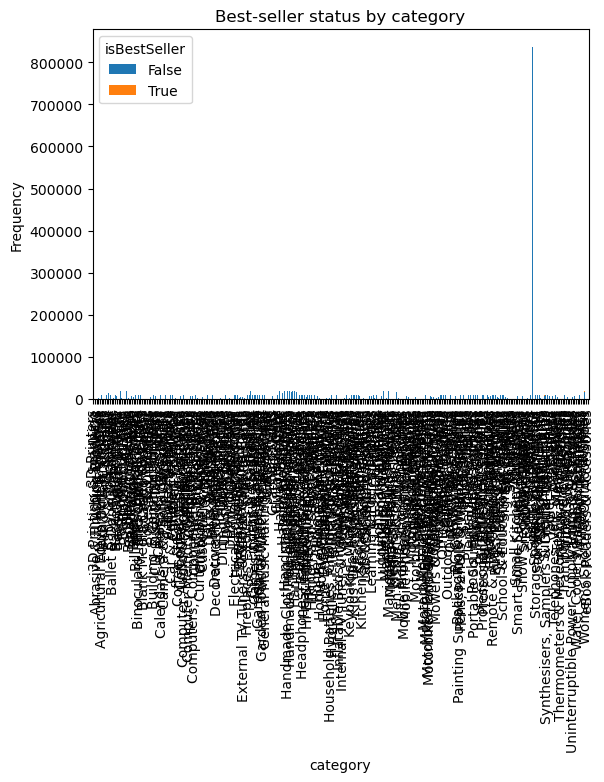

In [11]:
#Visualize the relationship between product categories and the best-seller status using a stacked bar chart
import matplotlib.pyplot as plt

contingency_table.plot(kind='bar', stacked=True)
plt.title('Best-seller status by category')
plt.ylabel('Frequency')
plt.show()

Part 2: Exploring Product Prices and Ratings Across Categories and Brands

0. Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [13]:
products_uk_df['price'].describe()

count    2.443651e+06
mean     8.924381e+01
std      3.456089e+02
min      0.000000e+00
25%      9.990000e+00
50%      1.909000e+01
75%      4.599000e+01
max      1.000000e+05
Name: price, dtype: float64

In [14]:
#Find the IQR
Q1 = products_uk_df['price'].quantile(0.25)
Q3 = products_uk_df['price'].quantile(0.75)
IQR = Q3 - Q1
IQR

36.0

In [15]:
#Remove the products priced below the first quartile minus 1.5 times the IQR
products_uk_df = products_uk_df[products_uk_df['price'] > Q1 - 1.5*IQR]

In [16]:
#Remove the products priced above the third quartile plus 1.5 times the IQR
products_uk_df = products_uk_df[products_uk_df['price'] < Q3 + 1.5*IQR]

1. Violin Plots:

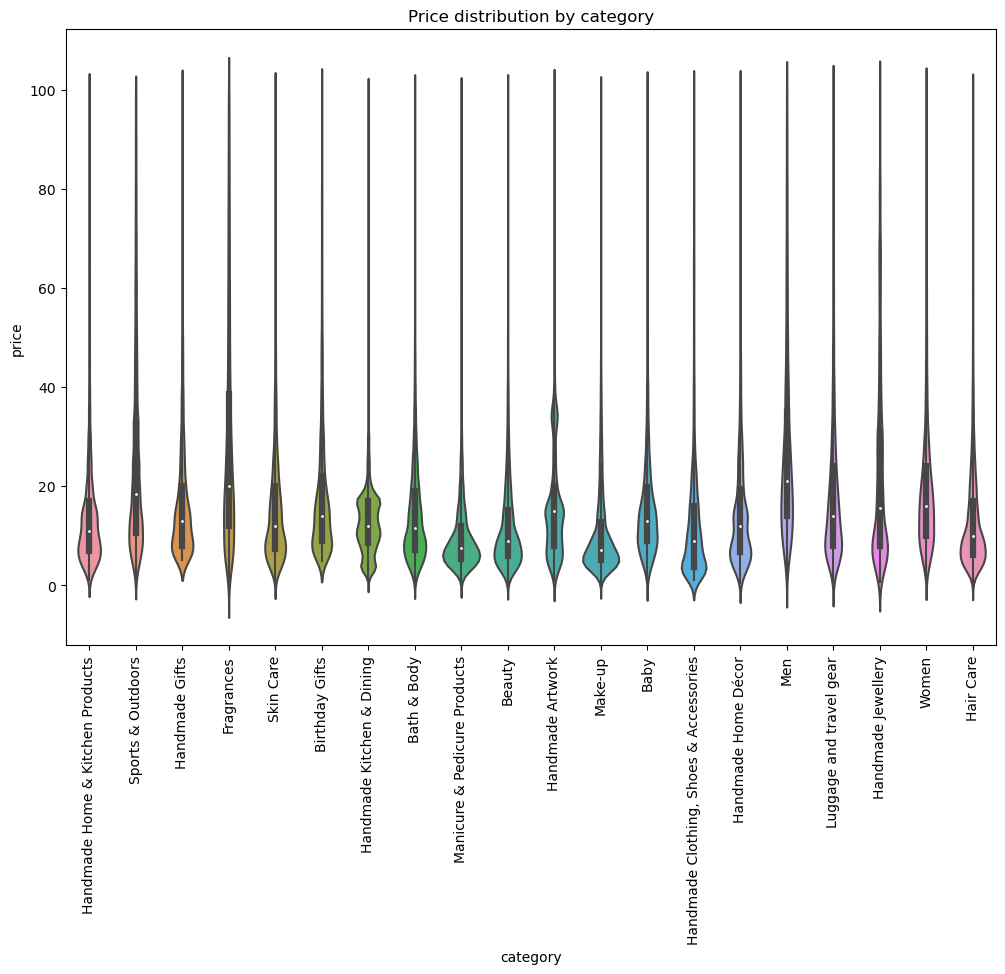

In [18]:
#Use a violin plot to visualize the distribution of price across different categories, Filter out the top 20 categories based on count for better visualization.
top_categories = products_uk_df['category'].value_counts().head(20).index
filtered_df = products_uk_df[products_uk_df['category'].isin(top_categories)]
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_df, x='category', y='price')
plt.xticks(rotation=90)
plt.title('Price distribution by category')
plt.show()


2. Bar Charts

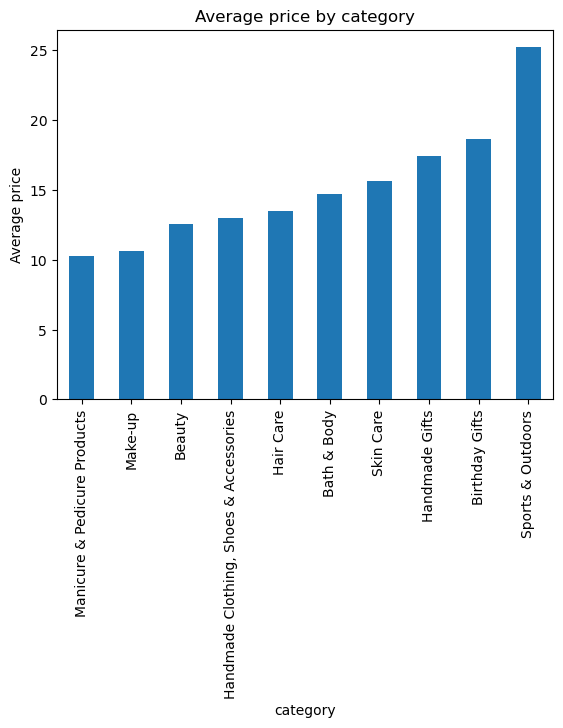

In [19]:
#Create a bar chart comparing the average price of products for the top 10 product categories (based on count)
top_categories = products_uk_df['category'].value_counts().head(10).index
filtered_df = products_uk_df[products_uk_df['category'].isin(top_categories)]
average_prices = filtered_df.groupby('category')['price'].mean().sort_values()
average_prices.plot(kind='bar')
plt.title('Average price by category')
plt.ylabel('Average price')
plt.show()

Sports & Outdoors is the most expensive category on average, while Home & Kitchen is the least expensive category on average.

3. Box Plots

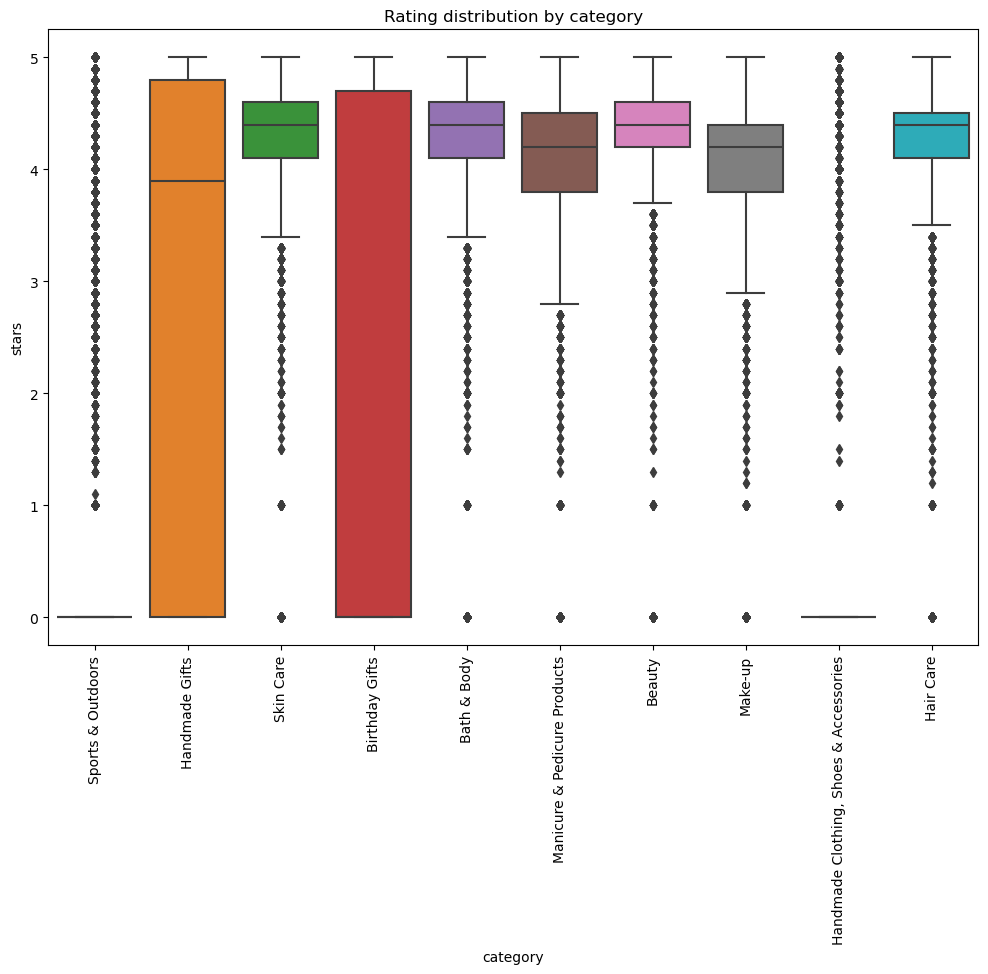

In [21]:
#Visualize the distribution of ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
top_categories = products_uk_df['category'].value_counts().head(10).index
filtered_df = products_uk_df[products_uk_df['category'].isin(top_categories)]
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x='category', y='stars')
plt.xticks(rotation=90)
plt.title('Rating distribution by category')
plt.show()

In [22]:
#Caterory with the highest median rating from customers
median_ratings = products_uk_df.groupby('category')['stars'].median().sort_values(ascending=False)
median_ratings.head(1)

category
Computer Memory    4.7
Name: stars, dtype: float64

Part 3: Investigating the Interplay Between Product Prices and Ratings

1. Correlation Coefficients

In [23]:
#Calculate the correlation coefficient between price and stars
products_uk_df[['price', 'stars']].corr()

,price,stars
price,1.000000,-0.077673
stars,-0.077673,1.000000


There is a weak negative correlation between price and stars

2. Visualizations

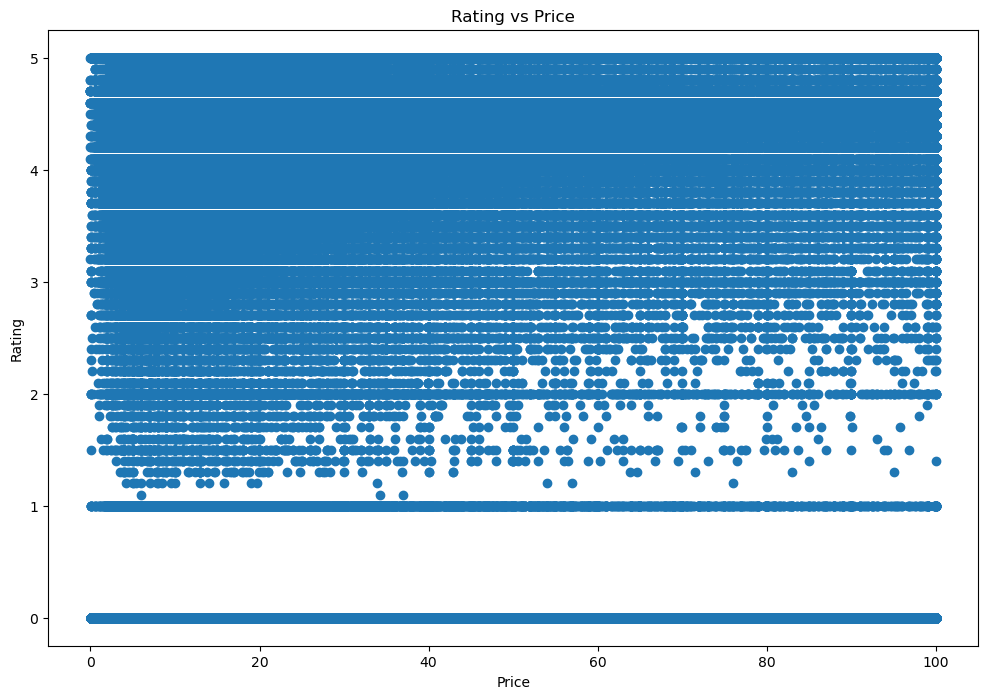

In [24]:
#Use a scatter plot to visualize the relationship between product rating and price
plt.figure(figsize=(12, 8))
plt.scatter(products_uk_df['price'], products_uk_df['stars'])
plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Rating vs Price')
plt.show()

We still some outliers with 0 ratings

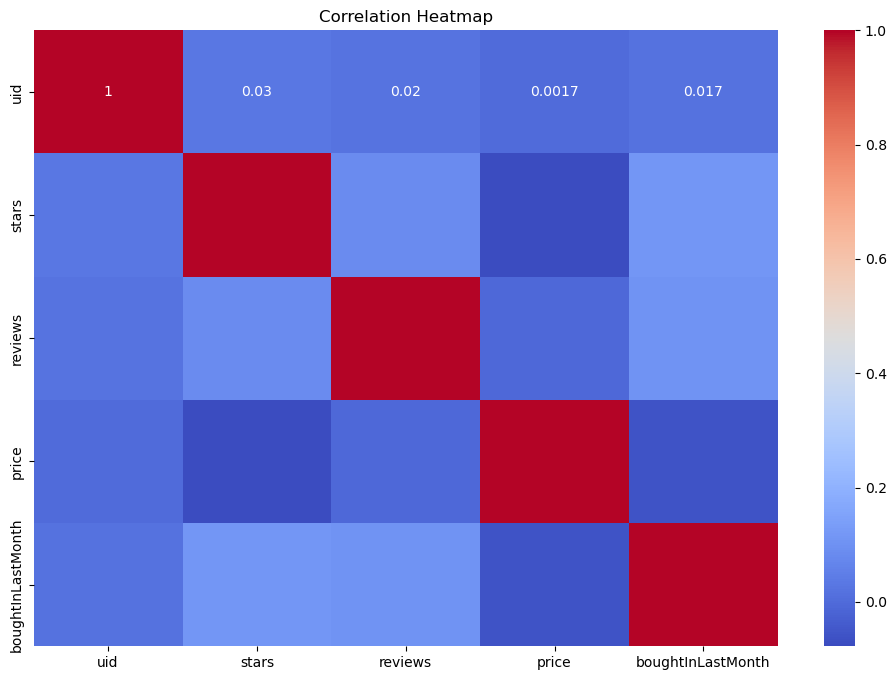

In [26]:
#Use a correlation heatmap to visualize correlations between all numerical variables

# Select only numerical columns
numerical_cols = products_uk_df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numerical_cols.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

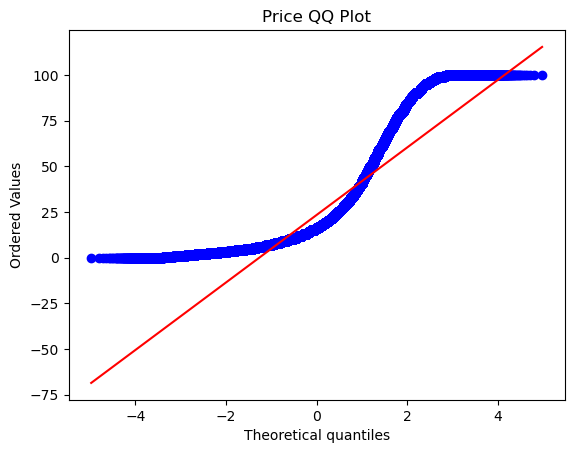

In [27]:
#Examine if product prices typically follow a normal distribution using a QQ plot
import scipy.stats as stats

stats.probplot(products_uk_df['price'], dist='norm', plot=plt)
plt.title('Price QQ Plot')
plt.show()